In [5]:
# Cell 1: Setup and Import
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries loaded!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries loaded!


In [6]:
# Cell 2: Load Data
df = pd.read_csv('/content/drive/MyDrive/PokemonDataScience/data/processed/pokemon_processed.csv')

print(f"Dataset loaded: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()


Dataset loaded: (1179, 58)

Columns: ['DexNumber', 'Name', 'Type', 'Type1', 'Type2', 'Abilities', 'Ability1', 'Ability2', 'HiddenAbility', 'Generation', 'Hp', 'Attack', 'Defense', 'SpecialAttack', 'SpecialDefense', 'Speed', 'TotalStats', 'Weight', 'Height', 'GenderProbM', 'NoGender', 'Category', 'CatchRate', 'EggCycles', 'EggGroup', 'EggGroup1', 'EggGroup2', 'LevelingRate', 'BaseFriendship', 'IsLegendary', 'IsMythical', 'IsUltraBeast', 'HasMega', 'EvoStage', 'TotalEvoStages', 'PreevoName', 'PhysicalSweeper', 'SpecialSweeper', 'PhysicalWall', 'SpecialWall', 'DamageFromNormal', 'DamageFromFighting', 'DamageFromFlying', 'DamageFromPoison', 'DamageFromGround', 'DamageFromRock', 'DamageFromBug', 'DamageFromGhost', 'DamageFromSteel', 'DamageFromFire', 'DamageFromWater', 'DamageFromGrass', 'DamageFromElectric', 'DamageFromPsychic', 'DamageFromIce', 'DamageFromDragon', 'DamageFromDark', 'DamageFromFairy']


,DexNumber,Name,Type,Type1,Type2,Abilities,Ability1,Ability2,HiddenAbility,Generation,...,DamageFromSteel,DamageFromFire,DamageFromWater,DamageFromGrass,DamageFromElectric,DamageFromPsychic,DamageFromIce,DamageFromDragon,DamageFromDark,DamageFromFairy
0,494,Victini,"['Psychic', 'Fire']",Psychic,Fire,['Victory Star'],Victory Star,NaN,[],V,...,0.5,0.5,2.0,0.50,1.0,0.5,0.5,1.0,2.0,0.5
1,1,Bulbasaur,"['Grass', 'Poison']",Grass,Poison,['Overgrow'],Overgrow,NaN,['Chlorophyll'],I,...,1.0,2.0,0.5,0.25,0.5,2.0,2.0,1.0,1.0,0.5
2,2,Ivysaur,"['Grass', 'Poison']",Grass,Poison,['Overgrow'],Overgrow,NaN,['Chlorophyll'],I,...,1.0,2.0,0.5,0.25,0.5,2.0,2.0,1.0,1.0,0.5
3,3,Venusaur,"['Grass', 'Poison']",Grass,Poison,['Overgrow'],Overgrow,NaN,['Chlorophyll'],I,...,1.0,2.0,0.5,0.25,0.5,2.0,2.0,1.0,1.0,0.5
4,4,Charmander,['Fire'],Fire,NaN,['Blaze'],Blaze,NaN,['Solar Power'],I,...,0.5,0.5,2.0,0.50,1.0,1.0,0.5,1.0,1.0,0.5


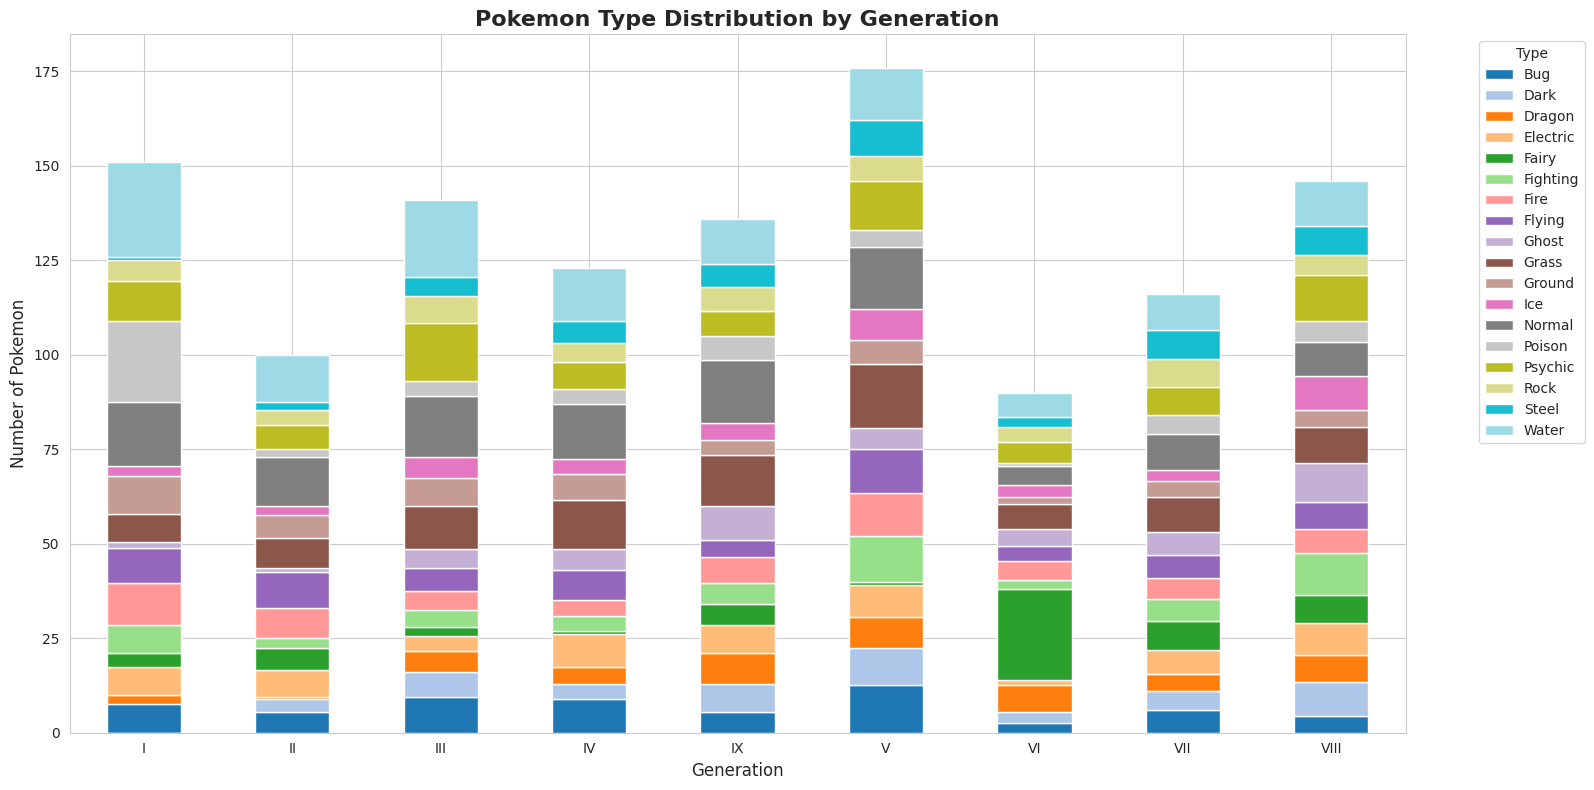

Type distribution by generation plotted!


In [8]:
# Cell 3: Type Distribution by Generation

# Convert Type column from string to list if needed
from ast import literal_eval
if isinstance(df['Type'].iloc[0], str):
    df['Type'] = df['Type'].apply(literal_eval)

# Create type counts by generation
# Each Pokemon counts as 0.5 for each type if dual-type
type_gen_data = []

for idx, row in df.iterrows():
    types = row['Type'] if isinstance(row['Type'], list) else [row['Type']]
    weight = 1.0 / len(types) if len(types) > 0 else 1.0

    for ptype in types:
        type_gen_data.append({
            'Generation': row['Generation'],
            'Type': ptype,
            'Weight': weight
        })

df_type_gen = pd.DataFrame(type_gen_data)
type_by_gen = df_type_gen.groupby(['Generation', 'Type'])['Weight'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
type_by_gen.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')
ax.set_title('Pokemon Type Distribution by Generation', fontsize=16, fontweight='bold')
ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Number of Pokemon', fontsize=12)
ax.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PokemonDataScience/figures/types_by_generation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Type distribution by generation plotted!")


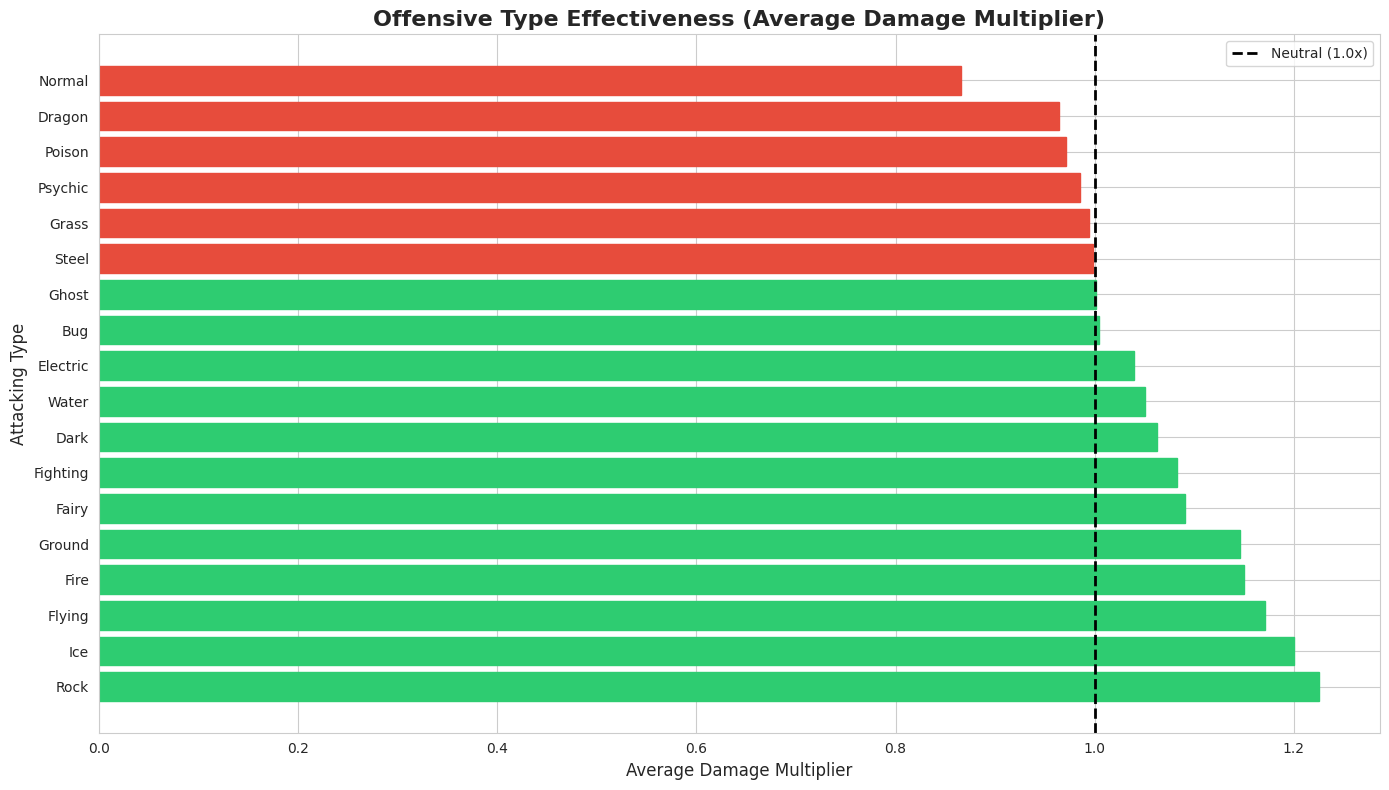


Best offensive type: Rock (1.225x)
Worst offensive type: Normal (0.866x)


In [9]:
# Cell 4: Average Damage Multiplier by Attacking Type

# Calculate average damage multiplier for each attacking type
damage_cols = [col for col in df.columns if col.startswith('DamageFrom')]
attack_types = [col.replace('DamageFrom', '') for col in damage_cols]

avg_damage = []
for col in damage_cols:
    attack_type = col.replace('DamageFrom', '')
    avg_multiplier = df[col].mean()
    avg_damage.append({
        'Type': attack_type,
        'AvgMultiplier': avg_multiplier
    })

df_damage = pd.DataFrame(avg_damage).sort_values('AvgMultiplier', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.barh(df_damage['Type'], df_damage['AvgMultiplier'])

# Color bars: green if > 1 (offensive), red if < 1 (weak)
colors = ['#2ecc71' if x > 1 else '#e74c3c' for x in df_damage['AvgMultiplier']]
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Neutral (1.0x)')
ax.set_xlabel('Average Damage Multiplier', fontsize=12)
ax.set_ylabel('Attacking Type', fontsize=12)
ax.set_title('Offensive Type Effectiveness (Average Damage Multiplier)', fontsize=16, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PokemonDataScience/figures/type_effectiveness.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest offensive type: {df_damage.iloc[0]['Type']} ({df_damage.iloc[0]['AvgMultiplier']:.3f}x)")
print(f"Worst offensive type: {df_damage.iloc[-1]['Type']} ({df_damage.iloc[-1]['AvgMultiplier']:.3f}x)")


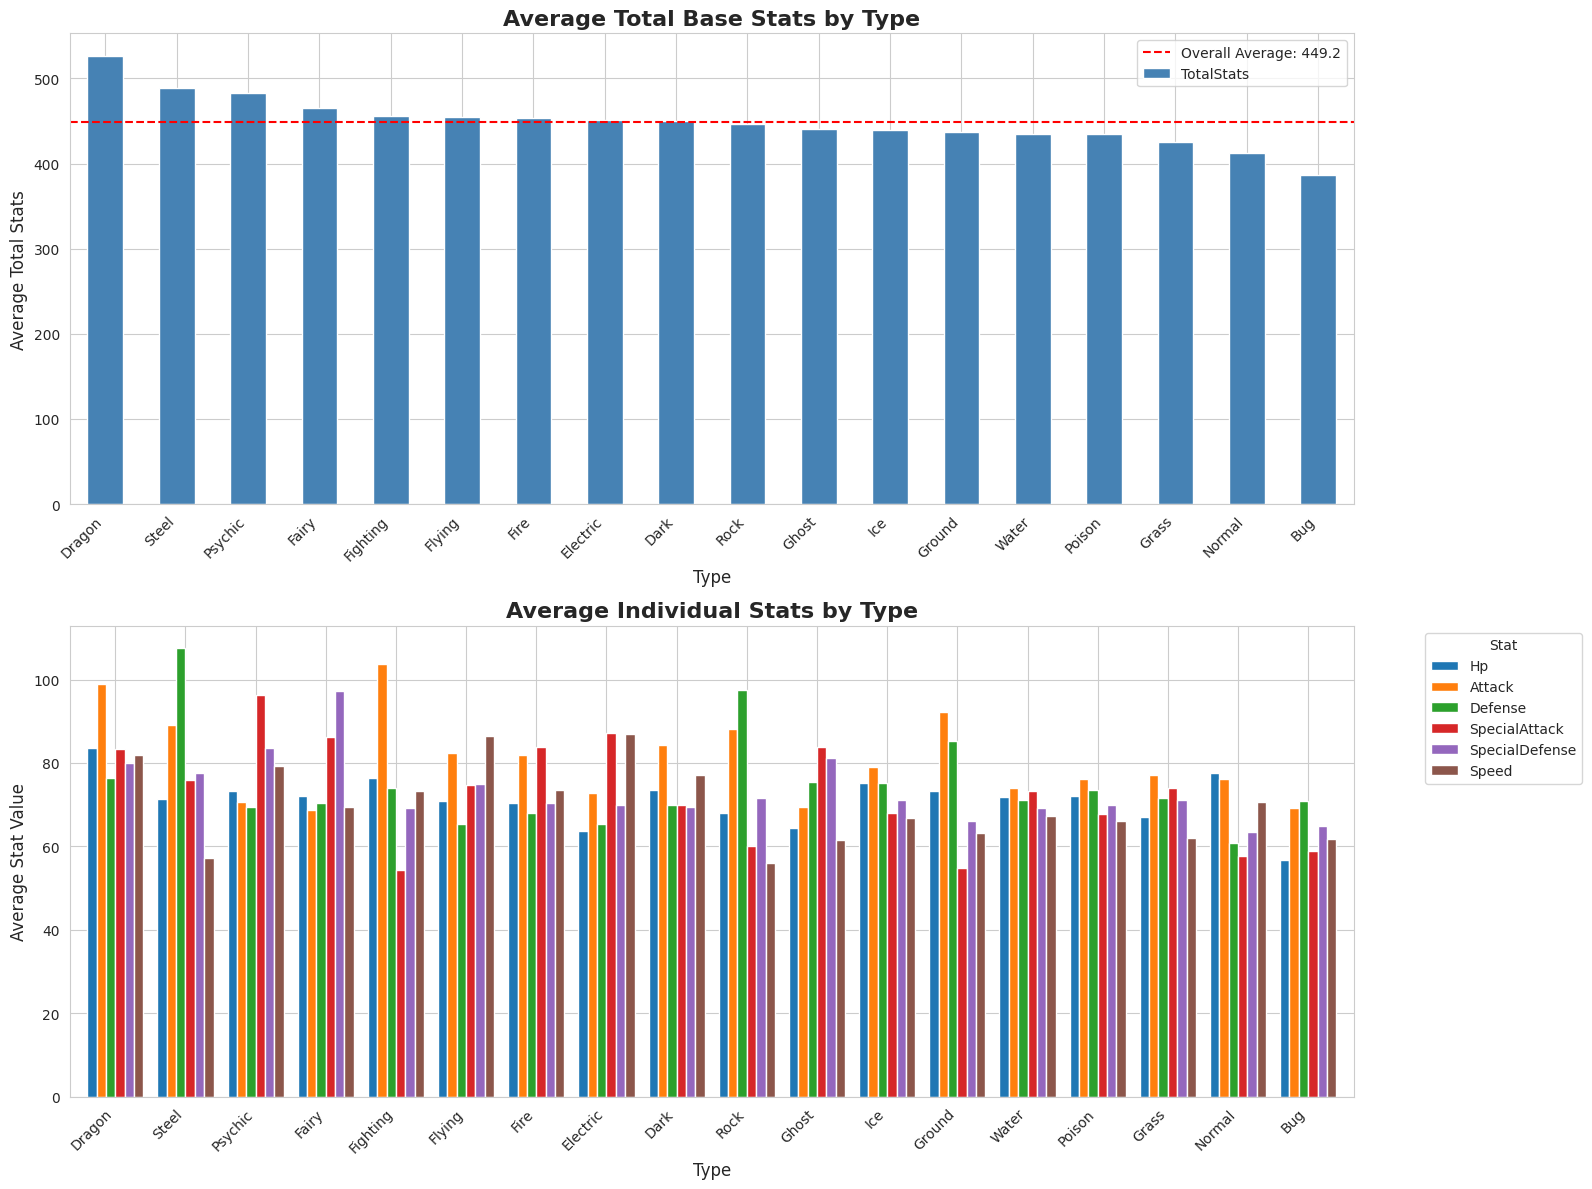


Strongest type (avg stats): Dragon (526.7)
Weakest type (avg stats): Bug (386.7)


In [10]:
# Cell 5: Average Stats by Type

stats_cols = ['Hp', 'Attack', 'Defense', 'SpecialAttack', 'SpecialDefense', 'Speed', 'TotalStats']
type_stats = df.groupby('Type1')[stats_cols].mean().round(1)
type_stats = type_stats.sort_values('TotalStats', ascending=False)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Total Stats
ax1 = axes[0]
type_stats['TotalStats'].plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Average Total Base Stats by Type', fontsize=16, fontweight='bold')
ax1.set_xlabel('Type', fontsize=12)
ax1.set_ylabel('Average Total Stats', fontsize=12)
ax1.axhline(y=type_stats['TotalStats'].mean(), color='red', linestyle='--',
            label=f'Overall Average: {type_stats["TotalStats"].mean():.1f}')
ax1.legend()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Individual Stats
ax2 = axes[1]
type_stats[['Hp', 'Attack', 'Defense', 'SpecialAttack', 'SpecialDefense', 'Speed']].plot(
    kind='bar', ax=ax2, width=0.8
)
ax2.set_title('Average Individual Stats by Type', fontsize=16, fontweight='bold')
ax2.set_xlabel('Type', fontsize=12)
ax2.set_ylabel('Average Stat Value', fontsize=12)
ax2.legend(title='Stat', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PokemonDataScience/figures/stats_by_type.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nStrongest type (avg stats): {type_stats.index[0]} ({type_stats.iloc[0]['TotalStats']:.1f})")
print(f"Weakest type (avg stats): {type_stats.index[-1]} ({type_stats.iloc[-1]['TotalStats']:.1f})")


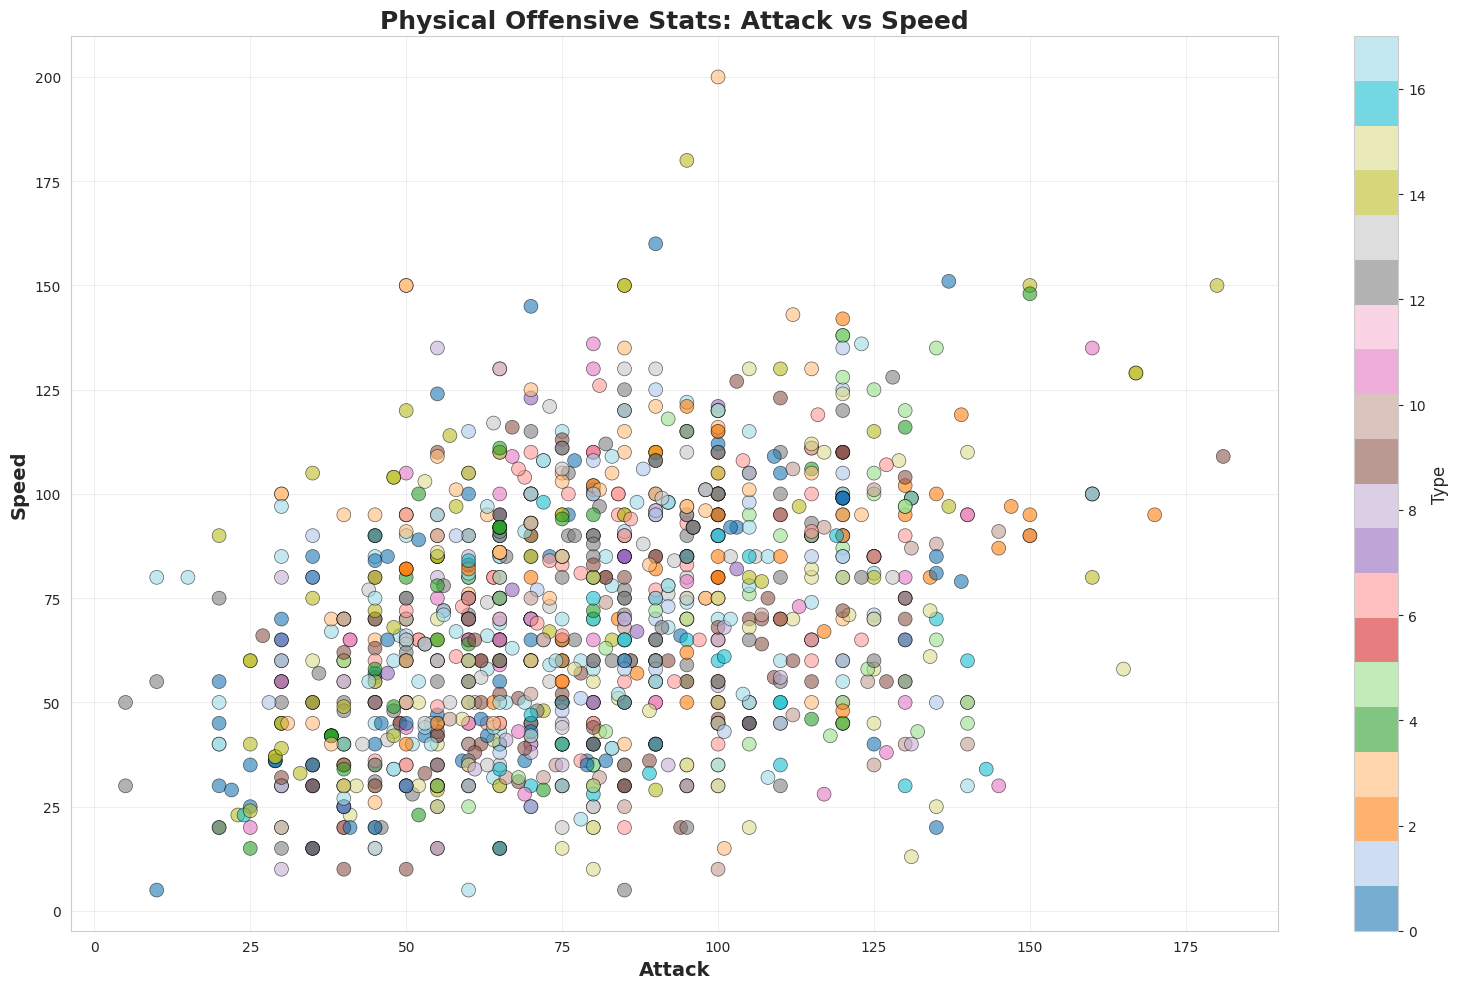

Physical sweeper analysis complete!


In [11]:
# Cell 6: Bivariate Stats Analysis - Physical Sweepers

fig, ax = plt.subplots(figsize=(16, 10))

# Scatter plot with density
scatter = ax.scatter(df['Attack'], df['Speed'],
                    c=df['Type1'].astype('category').cat.codes,
                    s=100, alpha=0.6, cmap='tab20', edgecolors='black', linewidths=0.5)

ax.set_xlabel('Attack', fontsize=14, fontweight='bold')
ax.set_ylabel('Speed', fontsize=14, fontweight='bold')
ax.set_title('Physical Offensive Stats: Attack vs Speed', fontsize=18, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Type', fontsize=12)

# Add marginal histograms would require seaborn jointplot, but here's the main plot
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PokemonDataScience/figures/attack_vs_speed.png', dpi=300, bbox_inches='tight')
plt.show()

print("Physical sweeper analysis complete!")


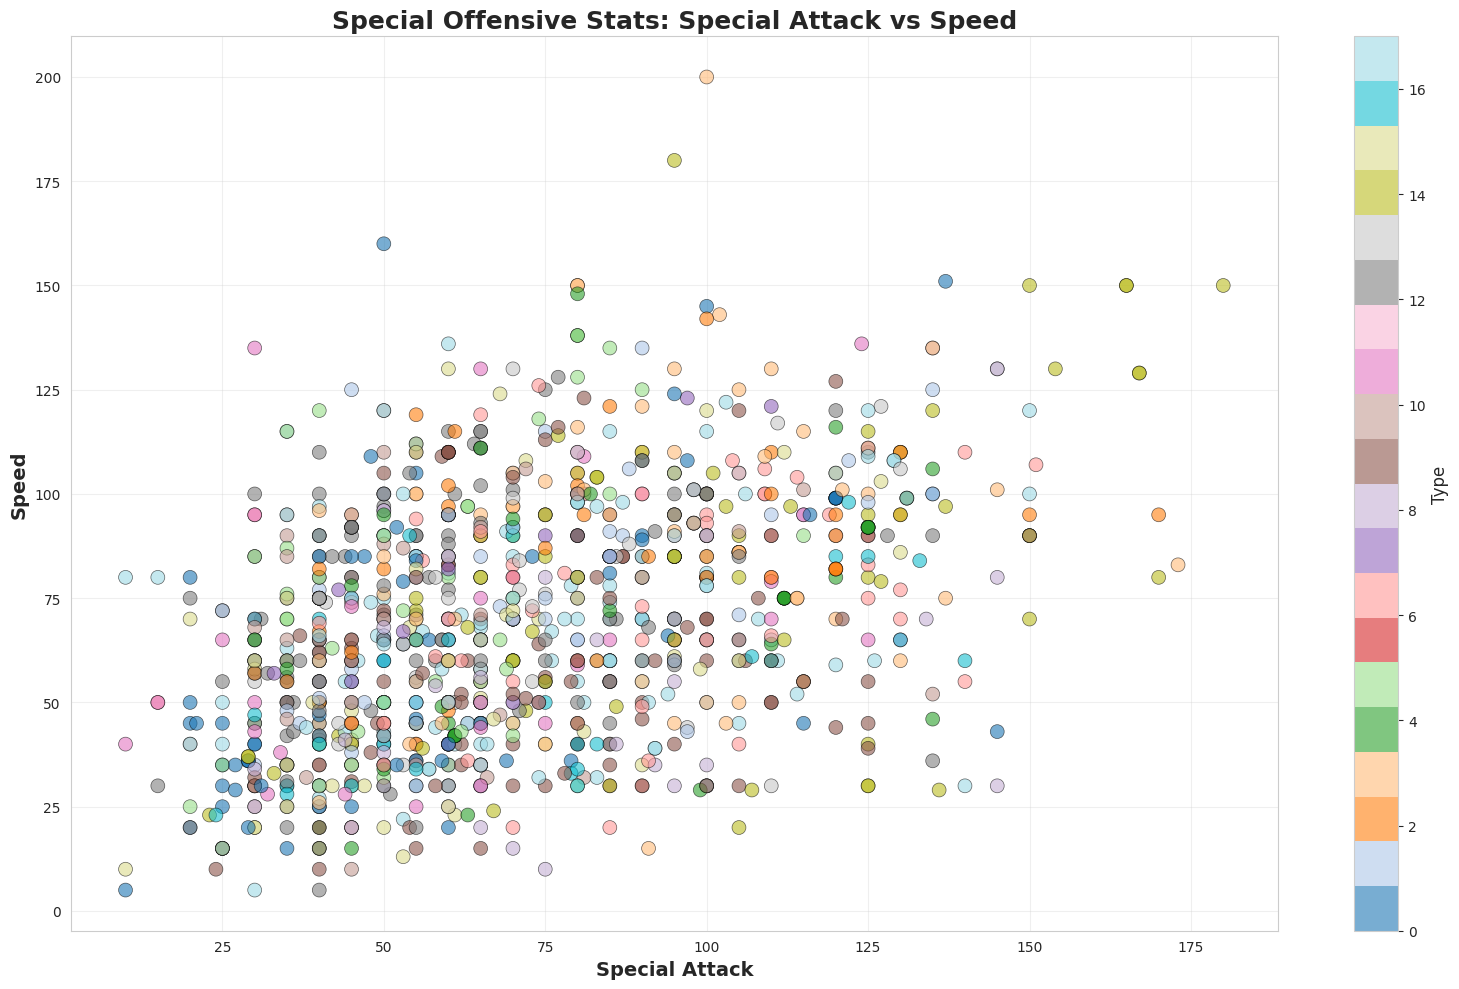

Special sweeper analysis complete!


In [12]:
# Cell 7: Special Sweepers Analysis

fig, ax = plt.subplots(figsize=(16, 10))

scatter = ax.scatter(df['SpecialAttack'], df['Speed'],
                    c=df['Type1'].astype('category').cat.codes,
                    s=100, alpha=0.6, cmap='tab20', edgecolors='black', linewidths=0.5)

ax.set_xlabel('Special Attack', fontsize=14, fontweight='bold')
ax.set_ylabel('Speed', fontsize=14, fontweight='bold')
ax.set_title('Special Offensive Stats: Special Attack vs Speed', fontsize=18, fontweight='bold')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Type', fontsize=12)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PokemonDataScience/figures/spattack_vs_speed.png', dpi=300, bbox_inches='tight')
plt.show()

print("Special sweeper analysis complete!")


In [13]:
# Cell 8: Top 5 Rankings

print("=" * 60)
print("TOP 5 POKEMON RANKINGS")
print("=" * 60)

# Top 5 HP
print("\n1. TOP 5 HIGHEST HP POKEMON")
print("-" * 40)
top_hp = df.nlargest(5, 'Hp')[['Name', 'Hp', 'Type1']]
for idx, row in top_hp.iterrows():
    print(f"{row['Name']}: {row['Hp']} ({row['Type1']} type)")

# Top 5 Attack
print("\n2. TOP 5 HIGHEST ATTACK POKEMON")
print("-" * 40)
top_atk = df.nlargest(5, 'Attack')[['Name', 'Attack', 'Type1']]
for idx, row in top_atk.iterrows():
    print(f"{row['Name']}: {row['Attack']} ({row['Type1']} type)")

# Top 5 Defense
print("\n3. TOP 5 HIGHEST DEFENSE POKEMON")
print("-" * 40)
top_def = df.nlargest(5, 'Defense')[['Name', 'Defense', 'Type1']]
for idx, row in top_def.iterrows():
    print(f"{row['Name']}: {row['Defense']} ({row['Type1']} type)")

# Top 5 Special Attack
print("\n4. TOP 5 HIGHEST SPECIAL ATTACK POKEMON")
print("-" * 40)
top_spatk = df.nlargest(5, 'SpecialAttack')[['Name', 'SpecialAttack', 'Type1']]
for idx, row in top_spatk.iterrows():
    print(f"{row['Name']}: {row['SpecialAttack']} ({row['Type1']} type)")

# Top 5 Special Defense
print("\n5. TOP 5 HIGHEST SPECIAL DEFENSE POKEMON")
print("-" * 40)
top_spdef = df.nlargest(5, 'SpecialDefense')[['Name', 'SpecialDefense', 'Type1']]
for idx, row in top_spdef.iterrows():
    print(f"{row['Name']}: {row['SpecialDefense']} ({row['Type1']} type)")

# Top 5 Speed
print("\n6. TOP 5 HIGHEST SPEED POKEMON")
print("-" * 40)
top_speed = df.nlargest(5, 'Speed')[['Name', 'Speed', 'Type1']]
for idx, row in top_speed.iterrows():
    print(f"{row['Name']}: {row['Speed']} ({row['Type1']} type)")

# Top 5 Sweepers/Walls using geometric means
print("\n7. TOP 5 PHYSICAL SWEEPERS (Attack × Speed)")
print("-" * 40)
top_psweep = df.nlargest(5, 'PhysicalSweeper')[['Name', 'Attack', 'Speed', 'PhysicalSweeper']]
for idx, row in top_psweep.iterrows():
    print(f"{row['Name']}: {row['PhysicalSweeper']:.2f} (Atk: {row['Attack']}, Spd: {row['Speed']})")

print("\n8. TOP 5 SPECIAL SWEEPERS (Sp.Atk × Speed)")
print("-" * 40)
top_ssweep = df.nlargest(5, 'SpecialSweeper')[['Name', 'SpecialAttack', 'Speed', 'SpecialSweeper']]
for idx, row in top_ssweep.iterrows():
    print(f"{row['Name']}: {row['SpecialSweeper']:.2f} (SpA: {row['SpecialAttack']}, Spd: {row['Speed']})")

print("\n9. TOP 5 PHYSICAL WALLS (HP × Defense)")
print("-" * 40)
top_pwall = df.nlargest(5, 'PhysicalWall')[['Name', 'Hp', 'Defense', 'PhysicalWall']]
for idx, row in top_pwall.iterrows():
    print(f"{row['Name']}: {row['PhysicalWall']:.2f} (HP: {row['Hp']}, Def: {row['Defense']})")

print("\n10. TOP 5 SPECIAL WALLS (HP × Sp.Def)")
print("-" * 40)
top_swall = df.nlargest(5, 'SpecialWall')[['Name', 'Hp', 'SpecialDefense', 'SpecialWall']]
for idx, row in top_swall.iterrows():
    print(f"{row['Name']}: {row['SpecialWall']:.2f} (HP: {row['Hp']}, SpD: {row['SpecialDefense']})")


TOP 5 POKEMON RANKINGS

1. TOP 5 HIGHEST HP POKEMON
----------------------------------------
Blissey: 255 (Normal type)
Chansey: 250 (Normal type)
Guzzlord: 223 (Dark type)
Zygarde Complete Forme: 216 (Dragon type)
Regidrago: 200 (Dragon type)

2. TOP 5 HIGHEST ATTACK POKEMON
----------------------------------------
Kartana: 181 (Grass type)
Deoxys Attack Forme: 180 (Psychic type)
Black Kyurem: 170 (Dragon type)
Necrozma Dusk Mane: 167 (Psychic type)
Necrozma Dawn Wings: 167 (Psychic type)

3. TOP 5 HIGHEST DEFENSE POKEMON
----------------------------------------
Shuckle: 230 (Bug type)
Stakataka: 211 (Rock type)
Steelix: 200 (Steel type)
Regirock: 200 (Rock type)
Avalugg: 184 (Ice type)

4. TOP 5 HIGHEST SPECIAL ATTACK POKEMON
----------------------------------------
Deoxys Attack Forme: 180 (Psychic type)
Xurkitree: 173 (Electric type)
White Kyurem: 170 (Dragon type)
Hoopa Unbound: 170 (Psychic type)
Necrozma Dusk Mane: 167 (Psychic type)

5. TOP 5 HIGHEST SPECIAL DEFENSE POKEMON
---

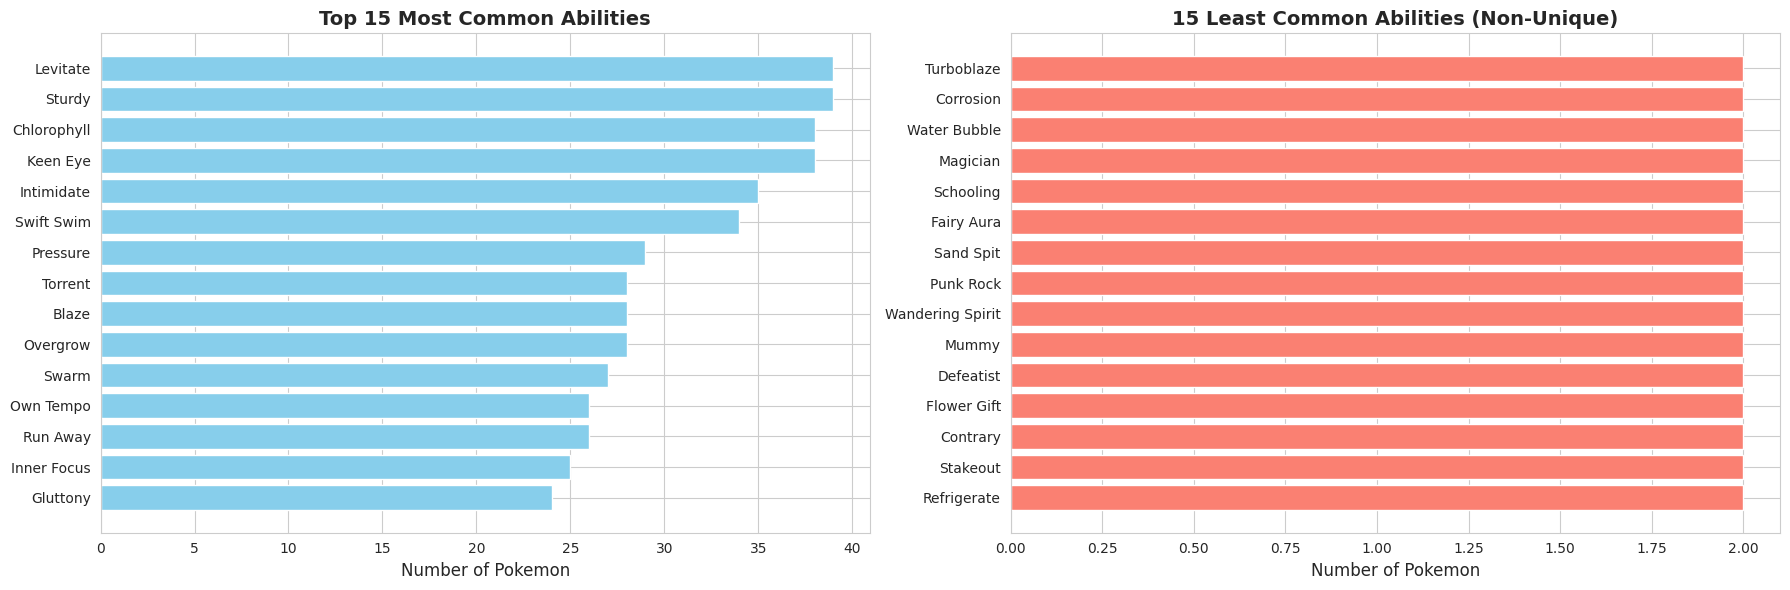


Total unique abilities: 270
Most common: Levitate (39 Pokemon)
Unique abilities (only 1 Pokemon): 66


In [14]:
# Cell 9: Ability Frequency Analysis

# Most common abilities
from ast import literal_eval
if isinstance(df['Abilities'].iloc[0], str):
    df['Abilities'] = df['Abilities'].apply(lambda x: literal_eval(x) if pd.notna(x) else [])

# Count all abilities
ability_counts = {}
for abilities in df['Abilities']:
    if isinstance(abilities, list):
        for ability in abilities:
            if ability and ability != 'None':
                ability_counts[ability] = ability_counts.get(ability, 0) + 1

ability_df = pd.DataFrame(list(ability_counts.items()), columns=['Ability', 'Count'])
ability_df = ability_df.sort_values('Count', ascending=False)

# Plot most common
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 15 most common
ax1 = axes[0]
top_abilities = ability_df.head(15)
ax1.barh(top_abilities['Ability'], top_abilities['Count'], color='skyblue')
ax1.set_xlabel('Number of Pokemon', fontsize=12)
ax1.set_title('Top 15 Most Common Abilities', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Bottom 15 least common (excluding unique)
ax2 = axes[1]
bottom_abilities = ability_df[ability_df['Count'] > 1].tail(15)
ax2.barh(bottom_abilities['Ability'], bottom_abilities['Count'], color='salmon')
ax2.set_xlabel('Number of Pokemon', fontsize=12)
ax2.set_title('15 Least Common Abilities (Non-Unique)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PokemonDataScience/figures/ability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal unique abilities: {len(ability_df)}")
print(f"Most common: {ability_df.iloc[0]['Ability']} ({ability_df.iloc[0]['Count']} Pokemon)")
print(f"Unique abilities (only 1 Pokemon): {len(ability_df[ability_df['Count'] == 1])}")


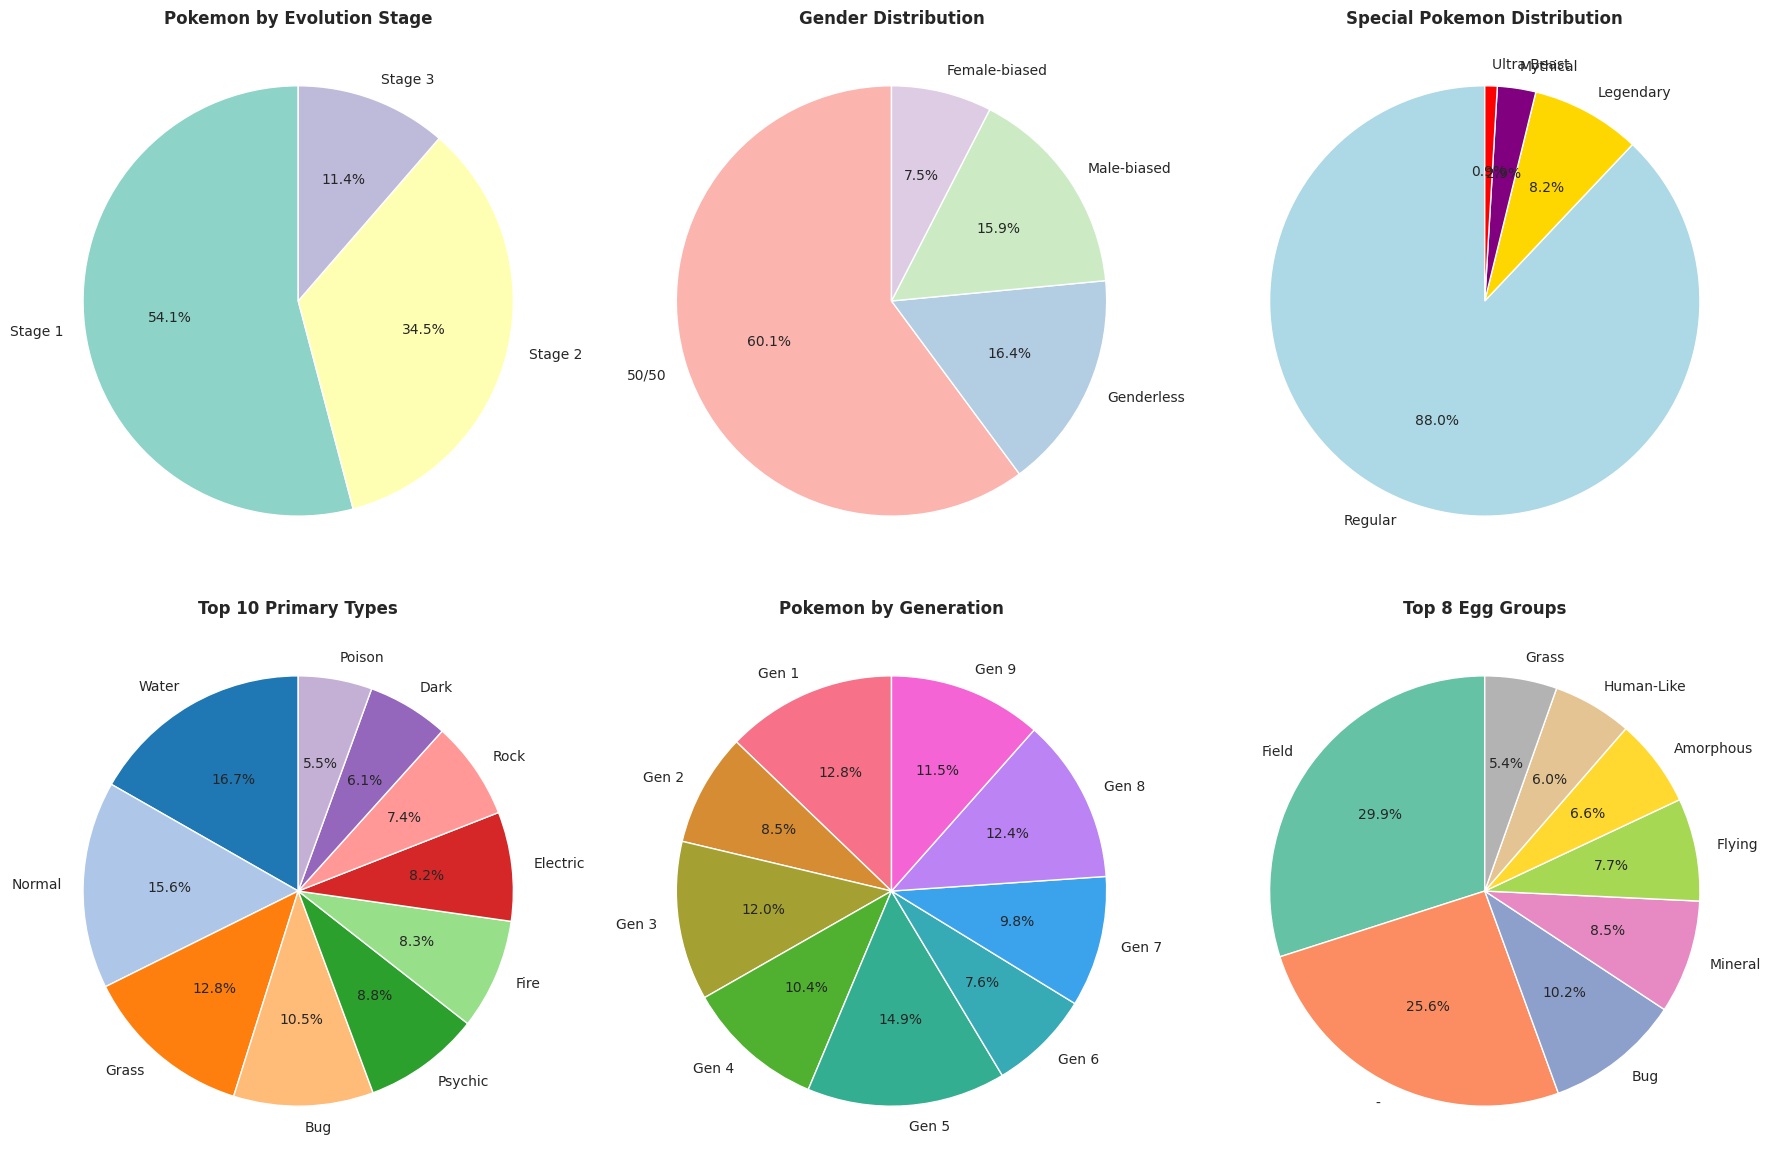

Pie chart analysis complete!


In [20]:
# Cell 10: Pie Charts for Categorical Data

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Evolution Stage Distribution
ax1 = axes[0, 0]
evo_counts = df['EvoStage'].value_counts()
ax1.pie(evo_counts, labels=[f'Stage {int(x)}' for x in evo_counts.index],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3'))
ax1.set_title('Pokemon by Evolution Stage', fontsize=12, fontweight='bold')

# Convert GenderProbM to numeric (invalid strings -> NaN)
df['GenderProbM'] = pd.to_numeric(df['GenderProbM'], errors='coerce')

# 2. Gender Distribution
ax2 = axes[0, 1]
gender_categories = []
for val in df['GenderProbM']:
    if pd.isna(val):
        gender_categories.append('Genderless')
    elif val == 0.5:
        gender_categories.append('50/50')
    elif val > 0.5:
        gender_categories.append('Male-biased')
    else:
        gender_categories.append('Female-biased')

gender_counts = pd.Series(gender_categories).value_counts()
ax2.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Pastel1')
)
ax2.set_title('Gender Distribution', fontsize=12, fontweight='bold')


# 3. Special Pokemon Types
ax3 = axes[0, 2]
special_counts = {
    'Regular': len(df[(df['IsLegendary'] == 0) & (df['IsMythical'] == 0) & (df['IsUltraBeast'] == 0)]),
    'Legendary': df['IsLegendary'].sum(),
    'Mythical': df['IsMythical'].sum(),
    'Ultra Beast': df['IsUltraBeast'].sum()
}
ax3.pie(special_counts.values(), labels=special_counts.keys(), autopct='%1.1f%%',
        startangle=90, colors=['lightblue', 'gold', 'purple', 'red'])
ax3.set_title('Special Pokemon Distribution', fontsize=12, fontweight='bold')

# 4. Primary Type Distribution (Top 10)
ax4 = axes[1, 0]
type_counts = df['Type1'].value_counts().head(10)
ax4.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('tab20'))
ax4.set_title('Top 10 Primary Types', fontsize=12, fontweight='bold')

# 5. Generation Distribution
ax5 = axes[1, 1]
# --- Convert Roman numerals in Generation column to integers ---
roman_to_int = {
    'I': 1, 'II': 2, 'III': 3, 'IV': 4,
    'V': 5, 'VI': 6, 'VII': 7, 'VIII': 8,
    'IX': 9, 'X': 10
}

df['Generation'] = df['Generation'].apply(lambda x: roman_to_int.get(x, x))
df['Generation'] = pd.to_numeric(df['Generation'], errors='coerce')

gen_counts = df['Generation'].value_counts().sort_index()
ax5.pie(
    gen_counts,
    labels=[f'Gen {int(x)}' for x in gen_counts.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('husl', len(gen_counts))
)
ax5.set_title('Pokemon by Generation', fontsize=12, fontweight='bold')


# 6. Egg Group Distribution (Top 8)
ax6 = axes[1, 2]
egg_counts = df['EggGroup1'].value_counts().head(8)
ax6.pie(egg_counts, labels=egg_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('Set2'))
ax6.set_title('Top 8 Egg Groups', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PokemonDataScience/figures/pie_charts.png', dpi=300, bbox_inches='tight')
plt.show()

print("Pie chart analysis complete!")


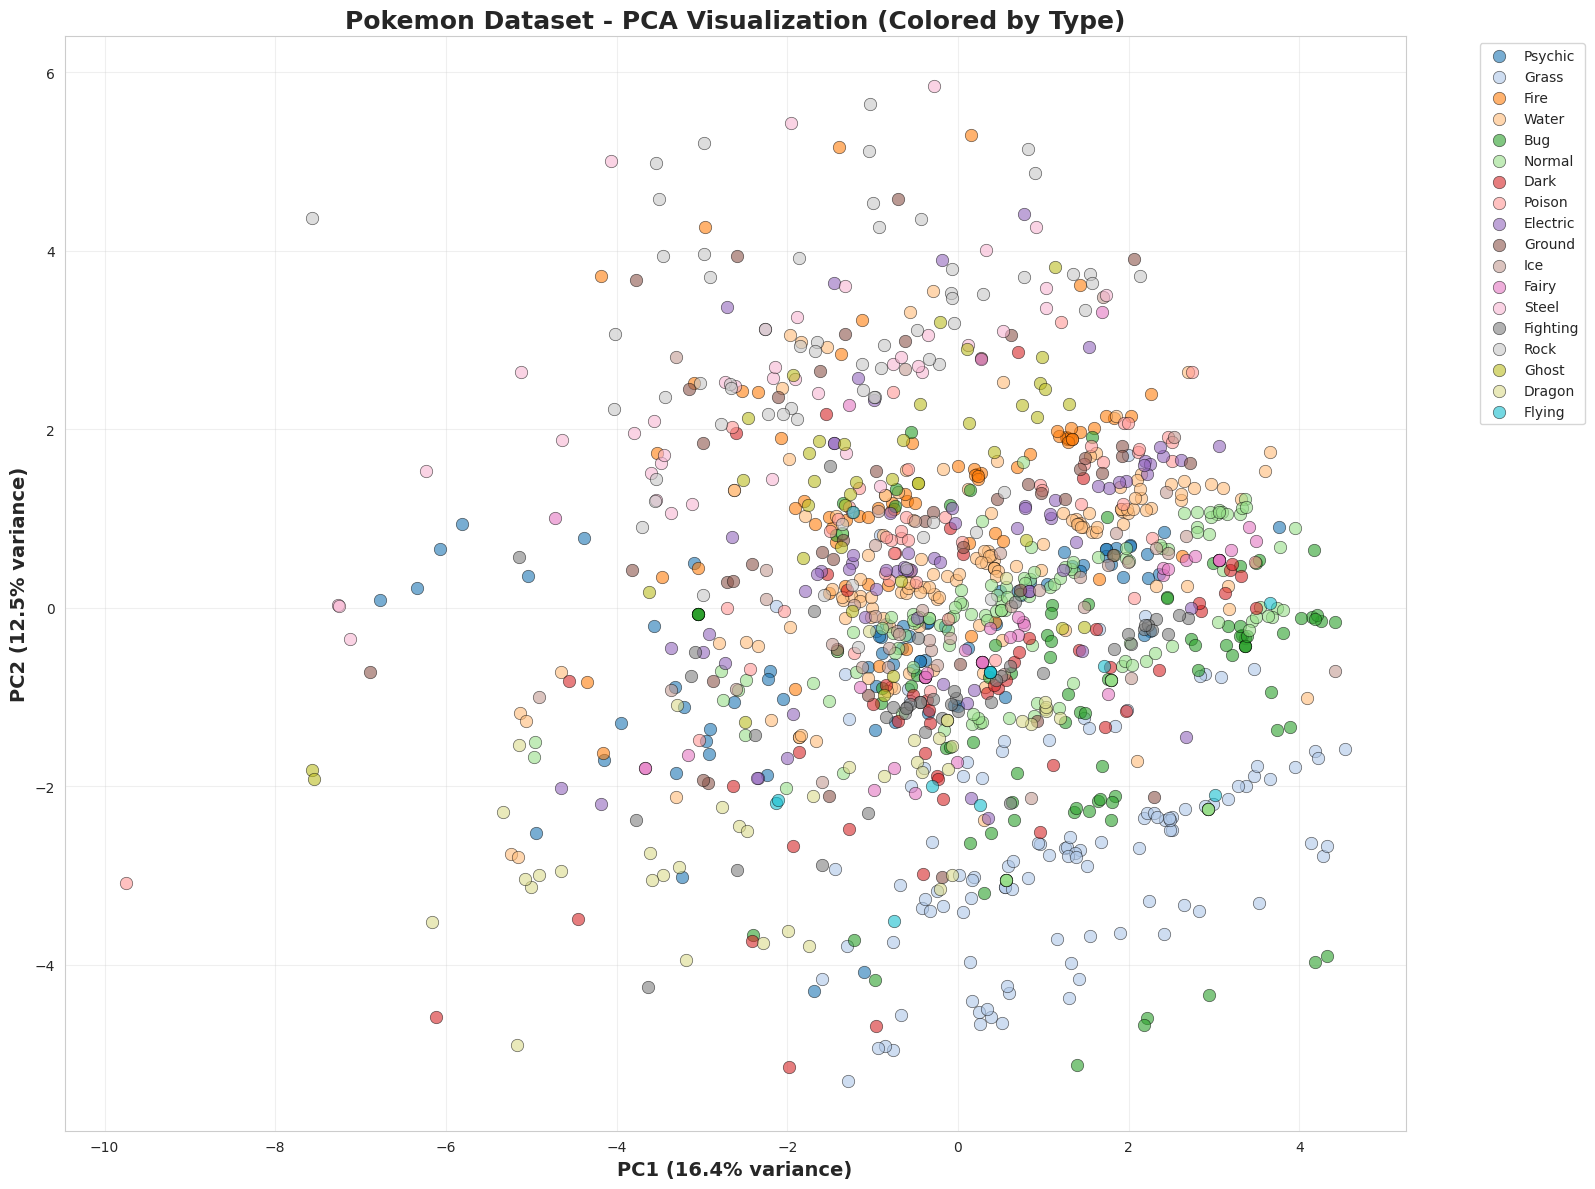


PCA Analysis Complete!
PC1 explains 16.36% of variance
PC2 explains 12.54% of variance
Total variance explained: 28.90%


In [16]:
# Cell 11: PCA Dimensionality Reduction

# Prepare data for PCA (only numerical features)
pca_cols = ['Hp', 'Attack', 'Defense', 'SpecialAttack', 'SpecialDefense', 'Speed',
            'Weight', 'Height', 'CatchRate', 'EggCycles']

# Add damage multipliers
damage_cols = [col for col in df.columns if col.startswith('DamageFrom')]
pca_cols.extend(damage_cols)

# Filter and clean data
X_pca = df[pca_cols].dropna()
indices = X_pca.index

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA(n_components=2)
X_pca_transformed = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca_transformed[:, 0],
    'PC2': X_pca_transformed[:, 1],
    'Type': df.loc[indices, 'Type1'].values,
    'Name': df.loc[indices, 'Name'].values,
    'TotalStats': df.loc[indices, 'TotalStats'].values
})

# Plot
fig, ax = plt.subplots(figsize=(16, 12))

# Color by type
types = pca_df['Type'].unique()
type_colors = {t: plt.cm.tab20(i/len(types)) for i, t in enumerate(types)}

for ptype in types:
    mask = pca_df['Type'] == ptype
    ax.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'],
              label=ptype, alpha=0.6, s=80,
              c=[type_colors[ptype]], edgecolors='black', linewidths=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)',
             fontsize=14, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)',
             fontsize=14, fontweight='bold')
ax.set_title('Pokemon Dataset - PCA Visualization (Colored by Type)',
            fontsize=18, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/PokemonDataScience/figures/pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPCA Analysis Complete!")
print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")


In [17]:
# Cell 12: Summary Statistics

print("\n" + "=" * 60)
print("VISUALIZATION ANALYSIS COMPLETE")
print("=" * 60)
print("\nKey Findings:")
print(f"1. Total Pokemon analyzed: {len(df)}")
print(f"2. Most common type: {df['Type1'].value_counts().index[0]}")
print(f"3. Strongest type (avg): {type_stats.index[0]} ({type_stats.iloc[0]['TotalStats']:.1f} total stats)")
print(f"4. Best offensive type: {df_damage.iloc[0]['Type']} ({df_damage.iloc[0]['AvgMultiplier']:.3f}x avg)")
print(f"5. Most common ability: {ability_df.iloc[0]['Ability']} ({ability_df.iloc[0]['Count']} Pokemon)")
print("\nAll visualizations saved to figures/ folder!")
print("=" * 60)



VISUALIZATION ANALYSIS COMPLETE

Key Findings:
1. Total Pokemon analyzed: 1179
2. Most common type: Water
3. Strongest type (avg): Dragon (526.7 total stats)
4. Best offensive type: Rock (1.225x avg)
5. Most common ability: Levitate (39 Pokemon)

All visualizations saved to figures/ folder!
